#IS 675 Lab7: Recommender Systems
##1. Data understanding
We will use the MovieLense 1M ratings data (downloaded from http://www.grouplens.org/), which contains around 1,000,000 ratings (1-5) from 6,000 users on 4,000 movies.
### USERS FILE DESCRIPTION

User information is in the file "**users.dat**".

Gender is denoted by a "M" for male and "F" for female
Age is chosen from the following ranges:

1: "Under 18"

18: "18-24"

25: "25-34"

35: "35-44"

45: "45-49"

50: "50-55"

56: "56+"

Occupation is chosen from the following choices:

0: "other" or not specified

1: "academic/educator"

2: "artist"

3: "clerical/admin"

4: "college/grad student"

5: "customer service"

6: "doctor/health care"

7: "executive/managerial"

8: "farmer"

9: "homemaker"

10: "K-12 student"

11: "lawyer"

12: "programmer"

13: "retired"

14: "sales/marketing"

15: "scientist"

16: "self-employed"

17: "technician/engineer"

18: "tradesman/craftsman"

19: "unemployed"

20: "writer"


### MOVIES FILE DESCRIPTION

Movie information is in the file "**movies.dat**"

Titles are identical to titles provided by the IMDB (including year of release)
Genres are pipe-separated and are selected from the following genres:

Action

Adventure

Animation

Children's

Comedy

Crime

Documentary

Drama

Fantasy

Film-Noir

Horror

Musical

Mystery

Romance

Sci-Fi

Thriller

War

Western



### RATINGS FILE DESCRIPTION

All ratings are contained in the file "**ratings.dat**"

UserIDs range between 1 and 6040

MovieIDs range between 1 and 3952

Ratings are made on a 5-star scale (whole-star ratings only)

Unix Timestamp is represented in seconds since the epoch (the number of seconds that have elapsed since January 1, 1970)

Each user has at least 20 ratings

##2. Upload and clean the data

In [132]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
# Import needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from itertools import chain

In [134]:
# Read user data
u_columns = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users = pd.read_csv('/content/drive/MyDrive/IS675_data/users.dat', sep='::', names=u_columns, engine='python')
users

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [135]:
# Read movie data
m_columns = ['movie_id', 'title', 'genre']
movies = pd.read_csv('/content/drive/MyDrive/IS675_data/movies.dat', sep='::', names=m_columns, encoding='latin-1', engine='python')
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [136]:
# Read rating data
r_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/IS675_data/ratings.dat', sep = '::', names=r_columns, engine='python')
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [137]:
# Create a merged DataFrame
movie_ratings = pd.merge(movies, ratings)
MovieLense = pd.merge(movie_ratings, users)
MovieLense

,movie_id,title,genre,user_id,rating,timestamp,gender,age,occupation,zip_code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50,9,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25,12,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25,17,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35,1,95370
...,...,...,...,...,...,...,...,...,...,...
1000204,3952,"Contender, The (2000)",Drama|Thriller,5812,4,992072099,F,25,7,92120
1000205,3952,"Contender, The (2000)",Drama|Thriller,5831,3,986223125,M,25,1,92120
1000206,3952,"Contender, The (2000)",Drama|Thriller,5837,4,1011902656,M,25,7,60607
1000207,3952,"Contender, The (2000)",Drama|Thriller,5927,1,979852537,M,35,14,10003


In [138]:
# Examine the first few rows
MovieLense.head()

,movie_id,title,genre,user_id,rating,timestamp,gender,age,occupation,zip_code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50,9,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25,12,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25,17,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35,1,95370


##3. Preprocess the data

In [139]:
# Encode movie_id and user_id
label_encoder = preprocessing.LabelEncoder()
ratings['movie_id'] = label_encoder.fit_transform(ratings['movie_id'])
ratings['user_id'] = label_encoder.fit_transform(ratings['user_id'])
ratings

,user_id,movie_id,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291
...,...,...,...,...
1000204,6039,1019,1,956716541
1000205,6039,1022,5,956704887
1000206,6039,548,5,956704746
1000207,6039,1024,4,956715648


In [140]:
# Sort data based on 'user_id' and 'timestamp'
ratings = ratings.sort_values(by=['user_id', 'timestamp'])
ratings

,user_id,movie_id,rating,timestamp
31,0,2969,4,978300019
22,0,1178,5,978300055
27,0,1574,4,978300055
37,0,957,5,978300055
24,0,2147,3,978300103
...,...,...,...,...
1000019,6039,2709,4,997454429
999988,6039,1741,4,997454464
1000172,6039,1618,3,997454464
1000167,6039,155,3,997454486


In [141]:
# Partition the data into test and train
test_data = ratings.drop_duplicates(subset=["user_id"], keep='last')
index_df = ratings.index.isin(test_data.index)
train_data = ratings.iloc[~index_df]
print(len(train_data), len(test_data))

994169 6040


In [142]:
# Remove the timestamp column
train_data = train_data[['user_id', 'movie_id', 'rating']]
test_data = test_data[['user_id', 'movie_id', 'rating']]
print(train_data.shape, test_data.shape)

(994169, 3) (6040, 3)


##4. Explore the MovieLense data

In [143]:
# Total number of users
user_num = len(ratings['user_id'].unique())
user_num

6040

In [144]:
# Total number of movies
movie_num = len(ratings['movie_id'].unique())
movie_num

3706

In [145]:
# Rating information
ratings['rating'].mean()

3.581564453029317

<Axes: xlabel='rating', ylabel='count'>

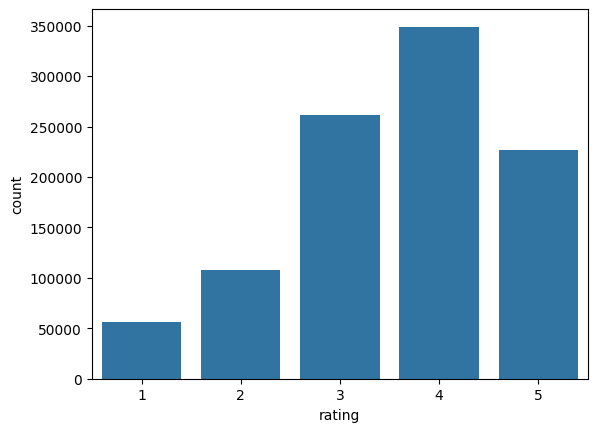

In [146]:
# Rating distribution
sns.countplot(x='rating', data=ratings)

## 5. Collaborative Filtering Recommender Systems

In [147]:
# Create user-item matrix for training and testing data
train_matrix = np.zeros([user_num, movie_num])
for line in train_data.itertuples():
  train_matrix[line.user_id, line.movie_id] = line.rating

test_matrix = np.zeros([user_num, movie_num])
for line in test_data.itertuples():
  test_matrix[line.user_id, line.movie_id] = line.rating

In [148]:
# calculate the average rating for each user
average_user_rating = np.true_divide(train_matrix.sum(1),(train_matrix!=0).sum(1))

# create a train_matrix_sp represents users' preferences on different movies
train_matrix_sp = csr_matrix(train_matrix, dtype=np.float64)
nz = train_matrix_sp.nonzero()
train_matrix_sp[nz] -= average_user_rating[nz[0]]
train_matrix_sp = train_matrix_sp.toarray()

# calculate the user and movie similarity
user_similarity = pairwise_distances(train_matrix_sp)
movie_similarity = pairwise_distances(train_matrix_sp.T)
np.fill_diagonal(user_similarity, 0)
np.fill_diagonal(movie_similarity, 0)
print(user_similarity)
print(movie_similarity)

[[ 0.         12.14767903  8.60791228 ...  6.71762742  9.28739332
  22.25245423]
 [12.14767903  0.         13.13868334 ... 12.27293771 13.6762553
  24.57772784]
 [ 8.60791228 13.13868334  0.         ...  8.17151664 10.39955863
  23.11314879]
 ...
 [ 6.71762742 12.27293771  8.17151664 ...  0.          9.11528597
  22.44387565]
 [ 9.28739332 13.6762553  10.39955863 ...  9.11528597  0.
  22.75256405]
 [22.25245423 24.57772784 23.11314879 ... 22.44387565 22.75256405
   0.        ]]
[[ 0.         51.42939133 50.77085734 ... 43.72368622 43.56110292
  46.25164572]
 [51.42939133  0.         34.92245194 ... 26.87519199 26.53723702
  31.84088456]
 [50.77085734 34.92245194  0.         ... 25.24973951 24.97181356
  30.4472768 ]
 ...
 [43.72368622 26.87519199 25.24973951 ...  0.          9.17803742
  19.10977498]
 [43.56110292 26.53723702 24.97181356 ...  9.17803742  0.
  18.60010796]
 [46.25164572 31.84088456 30.4472768  ... 19.10977498 18.60010796
   0.        ]]


In [149]:
# Create a collaborative filtering algorithm
zero_index = np.zeros(train_matrix_sp.shape)
zero_index[nz] = 1
def collaborative_filtering (type = 'user'):
  if type == 'user':
    pre_rating = average_user_rating[:, np.newaxis] + np.dot(user_similarity, train_matrix_sp)/np.dot(user_similarity, zero_index)
  if type == 'item':
    pre_rating = (np.dot(movie_similarity, train_matrix.T)/np.dot(movie_similarity, zero_index.T)).T
  return pre_rating

In [150]:
# make predictions
user_prediction = collaborative_filtering(type='user')
item_prediction = collaborative_filtering(type='item')
user_prediction = np.nan_to_num(user_prediction, nan=4)
item_prediction = np.nan_to_num(item_prediction, nan=4)

<ipython-input-149-48900d827913>:6: RuntimeWarning: invalid value encountered in divide
  pre_rating = average_user_rating[:, np.newaxis] + np.dot(user_similarity, train_matrix_sp)/np.dot(user_similarity, zero_index)


In [151]:
# Examine the evaluation results of user-based collaborative filtering on testing data: MAE and RMSE
MAE = mean_absolute_error(test_matrix[test_matrix!=0], user_prediction[test_matrix!=0])
RMSE = mean_squared_error(test_matrix[test_matrix!=0], user_prediction[test_matrix!=0], squared=False)
print("MAE:", MAE)
print("RMSE:", RMSE)

MAE: 0.7753529609966822
RMSE: 0.991180129199013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [152]:
# Examine the evaluation results of item-based collaborative filtering on testing data: MAE and RMSE
MAE = mean_absolute_error(test_matrix[test_matrix!=0], item_prediction[test_matrix!=0])
RMSE = mean_squared_error(test_matrix[test_matrix!=0], item_prediction[test_matrix!=0], squared=False)
print("MAE:", MAE)
print("RMSE:", RMSE)

MAE: 0.8958374281859105
RMSE: 1.1249154873319585


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


##6. Neural Collaborative Filtering

In [153]:
# Build a neural network on training data
class neural_network(nn.Module):
    def __init__(self,  emb_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, out_size):
        super().__init__()

        self.user_emb = nn.Embedding(user_num, emb_size)
        self.item_emb = nn.Embedding(movie_num, emb_size)

        self.network = nn.Sequential(
          nn.Linear(emb_size*2, hidden_size1),
          nn.ReLU(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, hidden_size3),
          nn.ReLU(),
          nn.Linear(hidden_size3, hidden_size4),
          nn.ReLU(),
          nn.Linear(hidden_size4, out_size))

    def forward(self, u_id, v_id):
        u = self.user_emb(u_id)
        v = self.item_emb(v_id)
        c = torch.cat([u,v], dim = 1)
        out = self.network(c)
        out_sig = torch.sigmoid(out) * 5.0
        return out_sig.squeeze()

In [154]:
# Create tensor from pandas dataframe
train_user_tensor=torch.tensor(train_data['user_id'].values)
train_movie_tensor=torch.tensor(train_data['movie_id'].values)
train_rating_tensor=torch.tensor(train_data['rating'].values)

test_user_tensor=torch.tensor(test_data['user_id'].values)
test_movie_tensor=torch.tensor(test_data['movie_id'].values)
test_rating_tensor=torch.tensor(test_data['rating'].values)

# Create tensor dataset
train_dataset=torch.utils.data.TensorDataset(train_user_tensor.long(),train_movie_tensor.long(),train_rating_tensor.float())
test_dataset=torch.utils.data.TensorDataset(test_user_tensor.long(),test_movie_tensor.long(),test_rating_tensor.float())

# Define training and testing data loader, and set batch size to 512
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=512,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=512,shuffle=False)

In [155]:
# Define training loop function
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase
        model.train()
        loss_train = 0.0
        for user_input, movie_input, labels in train_loader: # (user_input, movie_input, labels) are from (train_user_tensor, train_movie_tensor, train_rating_tensor) in train_dataset
                                                             # (user_input, movie_input, labels) are the inputs for each batch
            outputs = model(user_input, movie_input) # (user_input, movie_input) correspond to the u_id, v_id, which are the inputs of the forward(self, u_id, v_id) function
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs-1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))

In [156]:
# Model training
# %%time
torch.manual_seed(0)
NCF=neural_network(8,128,64,32,32,1)
Adam_optimizer=optim.Adam(NCF.parameters(),lr=0.02)
mse_loss=nn.MSELoss()

training_loop(n_epochs=8,optimizer=Adam_optimizer,model=NCF,loss_fn=mse_loss,train_loader=train_loader)

Epoch 0, Training loss 0.8868278534171755
Epoch 1, Training loss 0.8210895307032137
Epoch 2, Training loss 0.807401441428983
Epoch 3, Training loss 0.7988063778985296
Epoch 4, Training loss 0.7914991457663653
Epoch 5, Training loss 0.7788832995169686
Epoch 6, Training loss 0.7613126153373816
Epoch 7, Training loss 0.751397121793578


In [157]:
# Define testing function
def test(model, train_loader, test_loader):

  # testing phase
  model.eval()
  predict_train = []
  predict_test = []
  label_train = []
  label_test = []

  with torch.no_grad():
      for user_input, movie_input, labels in train_loader: # (user_input, movie_input, labels) are from (train_user_tensor, train_movie_tensor, train_rating_tensor) in train_dataset
                                                           # (user_input, movie_input, labels) are the inputs for each batch
          outputs = model(user_input, movie_input)         # (user_input, movie_input) correspond to the u_id, v_id, which are the inputs of the forward(self, u_id, v_id) function
          predict_train.append(outputs.tolist())
          label_train.append(labels.tolist())

      for user_input, movie_input, labels in test_loader: # (user_input, movie_input, labels) are from (test_user_tensor, test_movie_tensor, test_rating_tensor) in test_dataset
                                                          # (user_input, movie_input, labels) are the inputs for each batch
          outputs = model(user_input, movie_input)        # (user_input, movie_input) correspond to the u_id, v_id, which are the inputs of the forward(self, u_id, v_id) function
          predict_test.append(outputs.tolist())
          label_test.append(labels.tolist())

  MAE_train = mean_absolute_error(list(chain(*label_train)), list(chain(*predict_train)))
  RMSE_train = mean_squared_error(list(chain(*label_train)), list(chain(*predict_train)), squared=False)

  MAE_test = mean_absolute_error(list(chain(*label_test)), list(chain(*predict_test)))
  RMSE_test = mean_squared_error(list(chain(*label_test)), list(chain(*predict_test)), squared=False)

  print("Training MAE and RMSE:", MAE_train, RMSE_train)
  print()
  print("Testing MAE and RMSE:", MAE_test, RMSE_test)

In [158]:
# Examine evaluation results
test(model=NCF,train_loader=train_loader,test_loader=test_loader)

Training MAE and RMSE: 0.6708798517710148 0.8521906033807743

Testing MAE and RMSE: 0.7407560531272004 0.9438847948526806


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Q1- Why did we have to use "np.nan_to_num" in [30]? And why number 4 is used?

**Answer:** The np.nan_to_num function is used to replace NaN (Not a Number) values in the arrays user_prediction and item_prediction with a specified value, in this case, 4.

The primary reason for using 4 as the replacement for NaN values is to set a default rating that is favorable or neutral. In a 5-star rating system, a 4 is generally seen as a positive rating. By replacing NaN values with 4, the model avoids unintentionally penalizing items or users that didn't receive predictions, thus preventing a low rating bias in the recommendations.

Q2- We calculated the time that the NCF takes to train the model. If you want to see the training time for the manually implemented CF, which cell's run time do you consider?

**Answer:** We consider this line of code to see the training time for the manually implemented CF:

```
# Model training
# %%time
torch.manual_seed(0)
NCF=neural_network(8,128,64,32,32,1)
Adam_optimizer=optim.Adam(NCF.parameters(),lr=0.02)
mse_loss=nn.MSELoss()

training_loop(n_epochs=8,optimizer=Adam_optimizer,model=NCF,loss_fn=mse_loss,train_loader=train_loader)
```



Q3-Compare the results of NCF with our manually implemented CF model. Which one is faster? Which one is better? Which one do you prefer? Explain why.

**Answer:** The NCF model performs better than the manual CF model on both training and testing datasets, with lower MAE and RMSE values, indicating more accurate predictions. Its smaller gap between training and testing performance suggests better generalization.

**Close unnecessary logs before submitting to Canvas!**

In [159]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/IS675_lab07.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/IS675_lab07.ipynb to html
[NbConvertApp] Writing 742571 bytes to /content/drive/MyDrive/Colab Notebooks/IS675_lab07.html
